In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reset completo das configurações matplotlib
plt.rcdefaults()

# Configurações mínimas necessárias
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.edgecolor'] = 'black'

# Caminho para salvar imagens
image_path = '/home/cairo/mba/tcc-dsa-mcc/images/synth/'

# Garantir que seaborn não force Arial
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0)

def format_plot_tcc():
    """Aplica formatação padrão para gráficos do TCC"""
    ax = plt.gca()
    
    # Remove grid e define fundo branco
    ax.grid(False)
    ax.set_facecolor('white')
    
    # Define todas as bordas com linha sólida preta de 1.5pt
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    
    # Configura cor dos ticks
    ax.tick_params(colors='black', labelsize=11)
    
    # Remove apenas o título do gráfico
    ax.set_title('')

def save_figure(filename, dpi=300):
    """Salva figura em PNG para inclusão no TCC"""
    plt.tight_layout()
    format_plot_tcc()
    plt.savefig(image_path + f'{filename}.png', dpi=dpi, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print(f"✅ Figura salva: {filename}.png")


### Análise janela 2021 - 2023

In [3]:
print("="*80)
print("EDA PARA MODELAGEM MMM - JANELA 2021-2023")
print("="*80)

# Carregar dados
df = pd.read_csv('/home/cairo/mba/tcc-dsa-mcc/data/mmm_data_synth.csv')

# Filtrar para janela MMM
df_mmm = df[(df['year'] >= 2021) & (df['year'] <= 2023)].copy()
df_excluded = df[(df['year'] < 2021) | (df['year'] > 2023)].copy()

print(f"\n1. DEFINIÇÃO DA JANELA TEMPORAL MMM:")
print(f"   • Dataset original: {len(df)} semanas ({df['year'].min()}-{df['year'].max()})")
print(f"   • Janela MMM selecionada: {len(df_mmm)} semanas (2021-2023)")
print(f"   • Dados excluídos: {len(df_excluded)} semanas ({len(df_excluded)/len(df)*100:.1f}%)")
print(f"   • Distribuição na janela MMM:")
for year in [2021, 2022, 2023]:
    year_count = len(df_mmm[df_mmm['year'] == year])
    print(f"     - {year}: {year_count} semanas")

EDA PARA MODELAGEM MMM - JANELA 2021-2023

1. DEFINIÇÃO DA JANELA TEMPORAL MMM:
   • Dataset original: 156 semanas (2021-2023)
   • Janela MMM selecionada: 156 semanas (2021-2023)
   • Dados excluídos: 0 semanas (0.0%)
   • Distribuição na janela MMM:
     - 2021: 52 semanas
     - 2022: 52 semanas
     - 2023: 52 semanas


### DISPONIBILIDADE DE DADOS

In [4]:
df_mmm.columns

Index(['date', 'year', 'week', 'month', 'revenue', 'google_spend',
       'meta_spend', 'tv_spend', 'google_impressions', 'google_clicks',
       'meta_impressions', 'meta_reach', 'meta_frequency', 'ga_total_users',
       'ga_new_users', 'ga_engaged_sessions', 'ga_page_views', 'selic_rate',
       'incc_index', 'true_base_revenue', 'true_google_contribution',
       'true_meta_contribution', 'true_tv_contribution'],
      dtype='object')


2. DISPONIBILIDADE DE DADOS POR CANAL (JANELA MMM):
   • Google Ads: 156/156 semanas (100.0%)
   • Google Analytics: 156/156 semanas (100.0%)
   • Meta Ads: 156/156 semanas (100.0%)
   • Vendas: 156/156 semanas (100.0%)
   • TV: 156/156 semanas (100.0%)
✅ Figura salva: figura_mmm_1_disponibilidade_dados.png


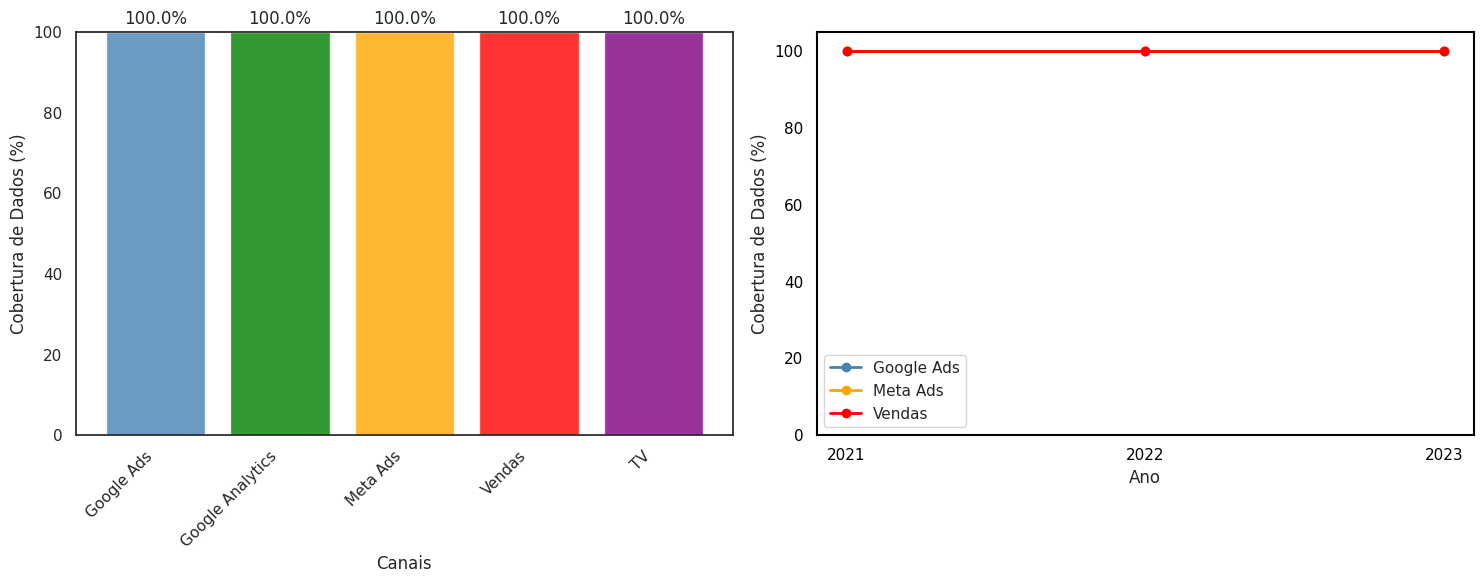

In [5]:
print(f"\n2. DISPONIBILIDADE DE DADOS POR CANAL (JANELA MMM):")

channels_mmm = {
    'Google Ads': df_mmm['google_spend'].count(),
    'Google Analytics': df_mmm['ga_total_users'].count(),
    'Meta Ads': df_mmm['meta_spend'].count(),
    'Vendas': df_mmm['revenue'].count(),
    'TV': df_mmm['tv_spend'].count()
}

for channel, count in channels_mmm.items():
    coverage = count / len(df_mmm) * 100
    print(f"   • {channel}: {count}/{len(df_mmm)} semanas ({coverage:.1f}%)")

# Gráfico de disponibilidade por canal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Cobertura por canal na janela MMM
channels = list(channels_mmm.keys())
coverages = [channels_mmm[ch]/len(df_mmm)*100 for ch in channels]
colors = ['steelblue', 'green', 'orange', 'red', 'purple']

bars1 = ax1.bar(channels, coverages, color=colors, alpha=0.8)
ax1.set_ylabel('Cobertura de Dados (%)')
ax1.set_xlabel('Canais')
ax1.set_ylim(0, 100)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Adicionar valores nas barras
for bar, cov in zip(bars1, coverages):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{cov:.1f}%', ha='center', va='bottom')

# Evolução da cobertura por ano
years = [2021, 2022, 2023]
coverage_by_year = {}
for channel in ['Google Ads', 'Meta Ads', 'Vendas']:
    coverage_by_year[channel] = []
    for year in years:
        year_data = df_mmm[df_mmm['year'] == year]
        if channel == 'Google Ads':
            coverage = year_data['google_spend'].count() / len(year_data) * 100
        elif channel == 'Meta Ads':
            coverage = year_data['meta_spend'].count() / len(year_data) * 100
        else:  # Vendas
            coverage = year_data['revenue'].count() / len(year_data) * 100
        coverage_by_year[channel].append(coverage)

for channel, color in zip(['Google Ads', 'Meta Ads', 'Vendas'], 
                         ['steelblue', 'orange', 'red']):
    ax2.plot(years, coverage_by_year[channel], 'o-', color=color, 
             label=channel, linewidth=2, markersize=6)

ax2.set_xlabel('Ano')
ax2.set_ylabel('Cobertura de Dados (%)')
ax2.set_ylim(0, 105)
ax2.legend()
ax2.set_xticks(years)

save_figure('figura_mmm_1_disponibilidade_dados')
plt.show()

### ANÁLISE FINANCEIRA DA JANELA

In [6]:
print(f"\n4. ANÁLISE FINANCEIRA (JANELA MMM 2021-2023):")

# Investimentos por canal
investments_mmm = {
    'Google Ads': df_mmm['google_spend'].sum(),
    'Meta Ads': df_mmm['meta_spend'].sum(),
    'TV': df_mmm['tv_spend'].sum()
}

total_investment = sum(v for v in investments_mmm.values() if not pd.isna(v))
total_revenue = df_mmm['revenue'].sum()

print(f"\n   INVESTIMENTOS NA JANELA MMM:")
for channel, investment in investments_mmm.items():
    if not pd.isna(investment) and investment > 0:
        share = investment / total_investment * 100
        print(f"   • {channel}: R$ {investment:,.2f} ({share:.1f}%)")

print(f"\n   • TOTAL INVESTIDO: R$ {total_investment:,.2f}")
print(f"   • RECEITA TOTAL: R$ {total_revenue:,.2f}")
if total_investment > 0:
    roi = total_revenue / total_investment
    print(f"   • ROI Aparente: {roi:.1f}x")

# Análise por ano
print(f"\n   EVOLUÇÃO ANUAL:")
for year in [2021, 2022, 2023]:
    year_data = df_mmm[df_mmm['year'] == year]
    year_investment = (year_data['google_spend'].sum() + 
                      year_data['meta_spend'].sum() + 
                      year_data['tv_spend'].sum())
    year_revenue = year_data['revenue'].sum()
    sales_weeks = year_data['revenue'].count()
    
    print(f"   • {year}:")
    print(f"     - Investimento: R$ {year_investment:,.2f}")
    print(f"     - Receita: R$ {year_revenue:,.2f}")
    print(f"     - Semanas com vendas: {sales_weeks}/{len(year_data)}")
    if sales_weeks > 0:
        avg_weekly_revenue = year_revenue / sales_weeks
        print(f"     - Receita média/semana: R$ {avg_weekly_revenue:,.2f}")


4. ANÁLISE FINANCEIRA (JANELA MMM 2021-2023):

   INVESTIMENTOS NA JANELA MMM:
   • Google Ads: R$ 353,986.54 (36.9%)
   • Meta Ads: R$ 277,791.50 (28.9%)
   • TV: R$ 328,127.39 (34.2%)

   • TOTAL INVESTIDO: R$ 959,905.43
   • RECEITA TOTAL: R$ 82,958,448.00
   • ROI Aparente: 86.4x

   EVOLUÇÃO ANUAL:
   • 2021:
     - Investimento: R$ 312,392.16
     - Receita: R$ 25,917,356.00
     - Semanas com vendas: 52/52
     - Receita média/semana: R$ 498,410.69
   • 2022:
     - Investimento: R$ 315,272.49
     - Receita: R$ 28,206,596.00
     - Semanas com vendas: 52/52
     - Receita média/semana: R$ 542,434.54
   • 2023:
     - Investimento: R$ 332,240.78
     - Receita: R$ 28,834,496.00
     - Semanas com vendas: 52/52
     - Receita média/semana: R$ 554,509.54


### QUALIDADE DOS DADOS

In [7]:
print(f"\n5. QUALIDADE DOS DADOS PARA MODELAGEM MMM:")

# Semanas com dados completos para MMM
complete_weeks = df_mmm[
    (df_mmm['revenue'].notna()) &
    (df_mmm['ga_total_users'].notna()) &
    ((df_mmm['google_spend'].notna()) | (df_mmm['meta_spend'].notna()))
].copy()

missing_sales = df_mmm['revenue'].isna().sum()
missing_ga = df_mmm['ga_total_users'].isna().sum()
no_media = df_mmm[
    (df_mmm['google_spend'].isna()) & 
    (df_mmm['meta_spend'].isna()) & 
    (df_mmm['tv_spend'].isna())
].shape[0]

print(f"\n   GAPS DE DADOS:")
print(f"   • Semanas sem dados de vendas: {missing_sales}/{len(df_mmm)} ({missing_sales/len(df_mmm)*100:.1f}%)")
print(f"   • Semanas sem Google Analytics: {missing_ga}/{len(df_mmm)} ({missing_ga/len(df_mmm)*100:.1f}%)")
print(f"   • Semanas sem investimento em mídia: {no_media}/{len(df_mmm)} ({no_media/len(df_mmm)*100:.1f}%)")
print(f"   • Semanas com dados MMM completos: {len(complete_weeks)}/{len(df_mmm)} ({len(complete_weeks)/len(df_mmm)*100:.1f}%)")



5. QUALIDADE DOS DADOS PARA MODELAGEM MMM:

   GAPS DE DADOS:
   • Semanas sem dados de vendas: 0/156 (0.0%)
   • Semanas sem Google Analytics: 0/156 (0.0%)
   • Semanas sem investimento em mídia: 0/156 (0.0%)
   • Semanas com dados MMM completos: 156/156 (100.0%)


### CORRELAÇÃO


6. ANÁLISE DE CORRELAÇÕES (JANELA MMM):

   CORRELAÇÕES COM RECEITA DE VENDAS:
   • google_spend: +0.128
   • google_clicks: +0.079
   • ga_new_users: +0.042
   • ga_total_users: +0.029
   • meta_reach: +0.019
✅ Figura salva: figura_mmm_2_correlacoes.png


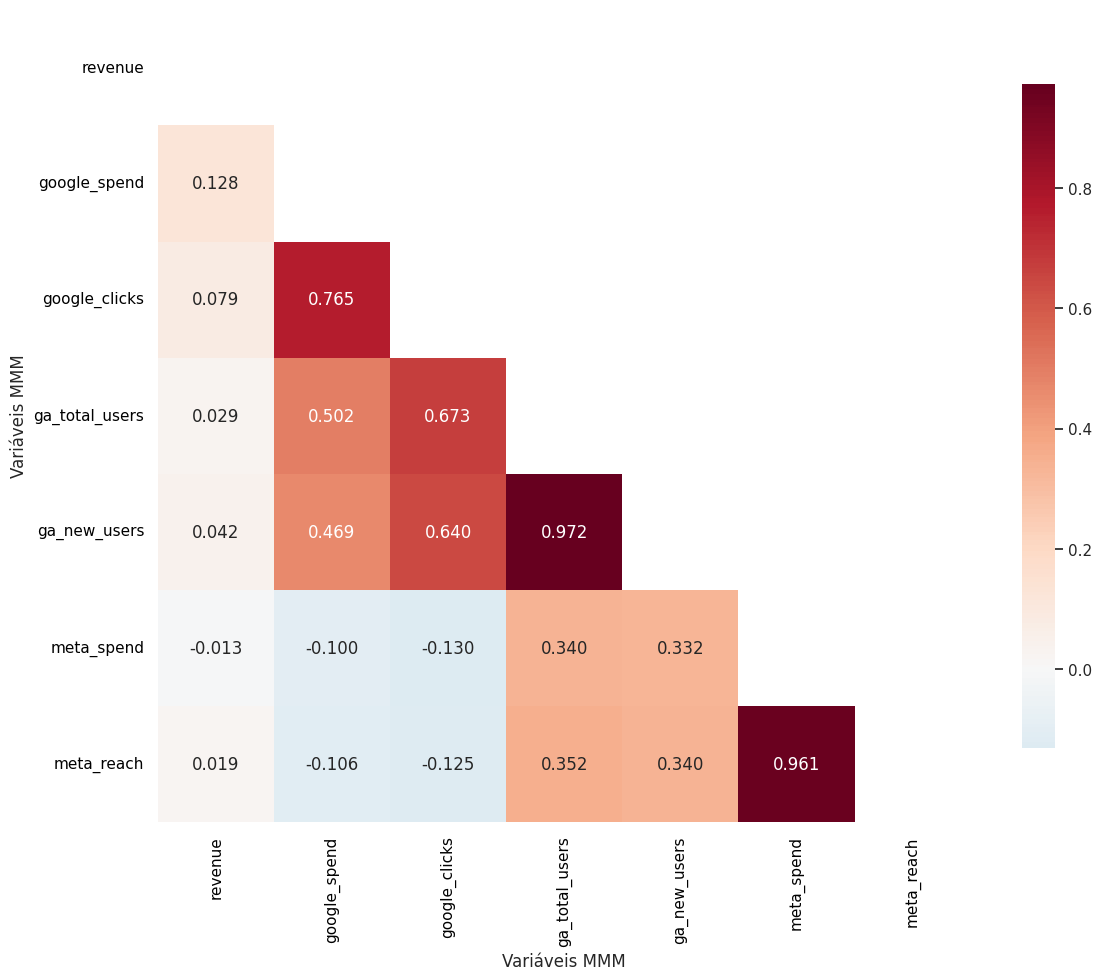

In [8]:
print(f"\n6. ANÁLISE DE CORRELAÇÕES (JANELA MMM):")

# Variáveis principais para correlação
mmm_vars = ['revenue', 'google_spend', 'google_clicks', 'google_conversions',
            'ga_total_users', 'ga_new_users', 'meta_spend', 'meta_reach']

# Filtrar apenas variáveis que existem
mmm_vars = [var for var in mmm_vars if var in df_mmm.columns]

# Calcular correlações apenas para dados da janela MMM
corr_matrix_mmm = df_mmm[mmm_vars].corr()

# Correlações mais importantes com vendas
print(f"\n   CORRELAÇÕES COM RECEITA DE VENDAS:")
if 'revenue' in corr_matrix_mmm.columns:
    sales_corr = corr_matrix_mmm['revenue'].abs().sort_values(ascending=False)[1:]
    for var, corr in sales_corr.head(5).items():
        direction = "+" if corr_matrix_mmm.loc[var, 'revenue'] > 0 else "-"
        print(f"   • {var}: {direction}{corr:.3f}")

# Heatmap de correlações para janela MMM
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix_mmm, dtype=bool))
sns.heatmap(corr_matrix_mmm, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8}, linewidths=0)
plt.xlabel('Variáveis MMM')
plt.ylabel('Variáveis MMM')
save_figure('figura_mmm_2_correlacoes')
plt.show()

### ANÁLISE DE SAZONALIDADE


7. ANÁLISE DE SAZONALIDADE (JANELA MMM):

   RECEITA POR TRIMESTRE (JANELA MMM):
   • Q1: R$ 544,411 ± R$ 106,538 (CV: 19.6%, n=39)
   • Q2: R$ 573,604 ± R$ 80,252 (CV: 14.0%, n=39)
   • Q3: R$ 513,266 ± R$ 63,550 (CV: 12.4%, n=39)
   • Q4: R$ 495,859 ± R$ 74,534 (CV: 15.0%, n=39)
✅ Figura salva: figura_mmm_3_sazonalidade.png


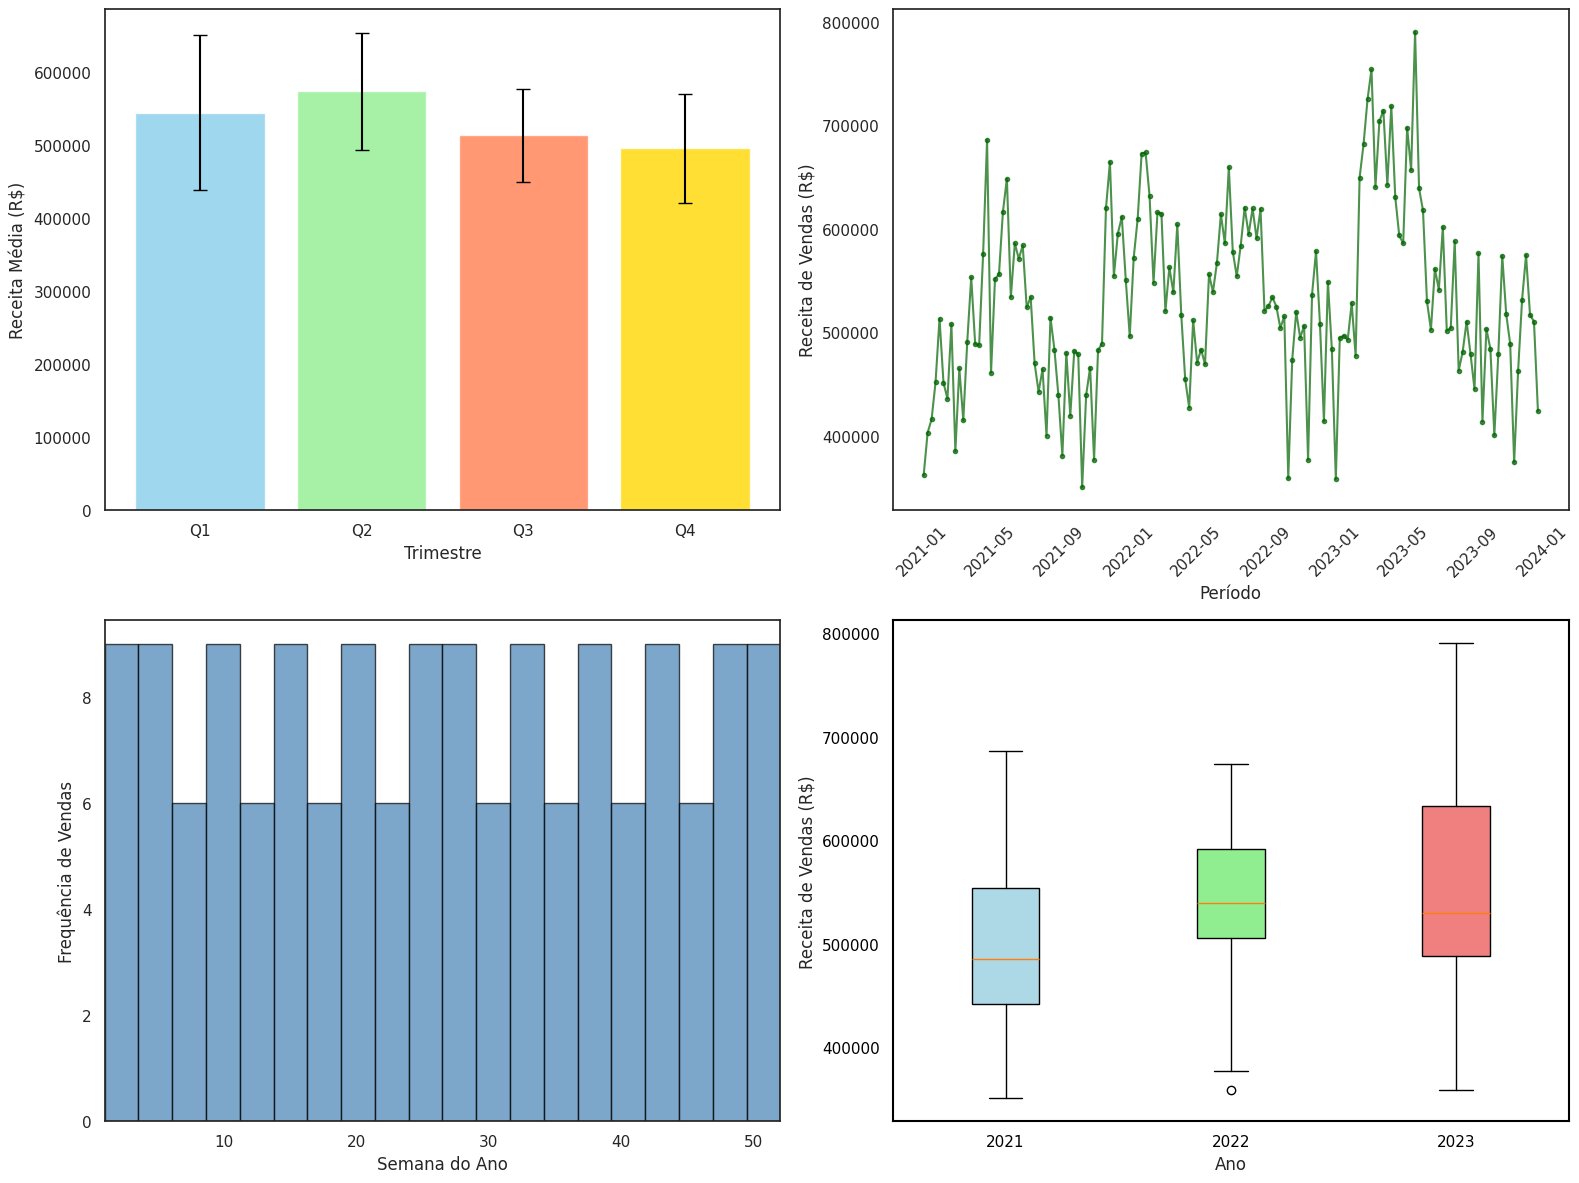

In [9]:
print(f"\n7. ANÁLISE DE SAZONALIDADE (JANELA MMM):")

# Análise por trimestre
df_mmm_seasonal = df_mmm.dropna(subset=['revenue']).copy()
df_mmm_seasonal['quarter'] = ((df_mmm_seasonal['week'] - 1) // 13) + 1
df_mmm_seasonal['quarter'] = df_mmm_seasonal['quarter'].clip(1, 4)

quarterly_stats = df_mmm_seasonal.groupby('quarter')['revenue'].agg(['mean', 'std', 'count'])
print(f"\n   RECEITA POR TRIMESTRE (JANELA MMM):")
for quarter in [1, 2, 3, 4]:
    if quarter in quarterly_stats.index:
        mean_val = quarterly_stats.loc[quarter, 'mean']
        std_val = quarterly_stats.loc[quarter, 'std']
        count_val = int(quarterly_stats.loc[quarter, 'count'])
        cv = (std_val / mean_val * 100) if mean_val > 0 else 0
        print(f"   • Q{quarter}: R$ {mean_val:,.0f} ± R$ {std_val:,.0f} "
              f"(CV: {cv:.1f}%, n={count_val})")

# Gráfico de sazonalidade
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Receita por trimestre
ax1 = axes[0, 0]
quarters = quarterly_stats.index
means = quarterly_stats['mean']
stds = quarterly_stats['std']

bars = ax1.bar(quarters, means, yerr=stds, capsize=5,
               color=['skyblue', 'lightgreen', 'coral', 'gold'], alpha=0.8)
ax1.set_xlabel('Trimestre')
ax1.set_ylabel('Receita Média (R$)')
ax1.set_xticks(quarters)
ax1.set_xticklabels([f'Q{q}' for q in quarters])

# 2. Evolução temporal das vendas
ax2 = axes[0, 1]
df_sales_time = df_mmm.dropna(subset=['revenue']).copy()
df_sales_time['date'] = pd.to_datetime(df_sales_time['year'].astype(str) + '-W' + 
                                       df_sales_time['week'].astype(str).str.zfill(2) + '-1',
                                       format='%Y-W%W-%w', errors='coerce')

ax2.plot(df_sales_time['date'], df_sales_time['revenue'], 'o-',
         color='darkgreen', markersize=3, alpha=0.7)
ax2.set_xlabel('Período')
ax2.set_ylabel('Receita de Vendas (R$)')
ax2.tick_params(axis='x', rotation=45)

# 3. Distribuição semanal
ax3 = axes[1, 0]
ax3.hist(df_mmm_seasonal['week'], bins=20, alpha=0.7, color='steelblue',
         edgecolor='black')
ax3.set_xlabel('Semana do Ano')
ax3.set_ylabel('Frequência de Vendas')
ax3.set_xlim(1, 52)

# 4. Boxplot por ano
ax4 = axes[1, 1]
sales_by_year = [df_mmm[df_mmm['year'] == year]['revenue'].dropna() 
                 for year in [2021, 2022, 2023]]
bp = ax4.boxplot(sales_by_year, labels=['2021', '2022', '2023'], 
                 patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
ax4.set_xlabel('Ano')
ax4.set_ylabel('Receita de Vendas (R$)')

save_figure('figura_mmm_3_sazonalidade')
plt.show()

### INVESTIMENTO POR CANAL


8. PERFORMANCE DOS CANAIS (JANELA MMM):

   GOOGLE ADS:
   • Semanas ativas: 156/156 (100.0%)
   • Investimento total: R$ 353,986.54
   • Investimento médio/semana: R$ 2,269.14
   • CPC médio: R$ 0.31
   • Total de cliques: 1,200,505

   META ADS:
   • Semanas ativas: 156/156 (100.0%)
   • Investimento total: R$ 277,791.50
   • Investimento médio/semana: R$ 1,780.71
   • Frequência média: 1.43
   • Alcance total: 23,564,584

   TV:
   • Semanas ativas: 33/156 (21.2%)
   • Investimento total: R$ 328,127.39
   • Investimento médio/semana: R$ 9,943.25
✅ Figura salva: figura_mmm_4_investimento_canais.png


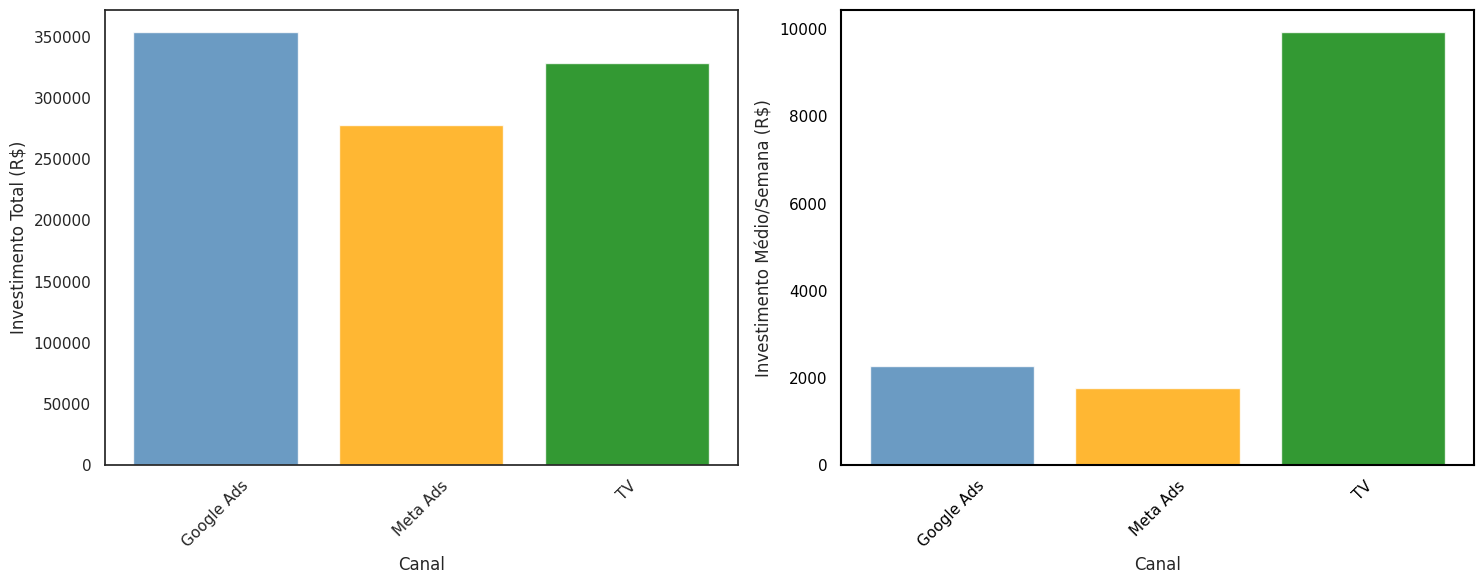

In [10]:
print(f"\n8. PERFORMANCE DOS CANAIS (JANELA MMM):")

# Métricas por canal
channels_performance = {}

# Google Ads
ga_data = df_mmm[df_mmm['google_spend'] > 0].copy()
if len(ga_data) > 0:
    channels_performance['Google Ads'] = {
        'weeks_active': len(ga_data),
        'total_investment': ga_data['google_spend'].sum(),
        'avg_weekly_investment': ga_data['google_spend'].mean(),
        'total_clicks': ga_data['google_clicks'].sum(),
        'avg_cpc': (ga_data['google_spend'] / ga_data['google_clicks']).mean()
    }

# Meta Ads  
meta_data = df_mmm[df_mmm['meta_spend'] > 0].copy()
if len(meta_data) > 0:
    channels_performance['Meta Ads'] = {
        'weeks_active': len(meta_data),
        'total_investment': meta_data['meta_spend'].sum(),
        'avg_weekly_investment': meta_data['meta_spend'].mean(),
        'total_reach': meta_data['meta_reach'].sum(),
        'avg_frequency': meta_data['meta_frequency'].mean()
    }

# TV
tv_data = df_mmm[df_mmm['tv_spend'] > 0].copy()
if len(tv_data) > 0:
    channels_performance['TV'] = {
        'weeks_active': len(tv_data),
        'total_investment': tv_data['tv_spend'].sum(),
        'avg_weekly_investment': tv_data['tv_spend'].mean(),
        #'total_insertions': tv_data['tv_insertions'].sum(),
        #'total_grp': tv_data['tv_grp'].sum()
    }

# Relatório de performance
for channel, metrics in channels_performance.items():
    print(f"\n   {channel.upper()}:")
    print(f"   • Semanas ativas: {metrics['weeks_active']}/{len(df_mmm)} "
          f"({metrics['weeks_active']/len(df_mmm)*100:.1f}%)")
    print(f"   • Investimento total: R$ {metrics['total_investment']:,.2f}")
    print(f"   • Investimento médio/semana: R$ {metrics['avg_weekly_investment']:,.2f}")
    
    if channel == 'Google Ads' and 'avg_cpc' in metrics:
        print(f"   • CPC médio: R$ {metrics['avg_cpc']:.2f}")
        print(f"   • Total de cliques: {int(metrics['total_clicks']):,}")
    elif channel == 'Meta Ads' and 'avg_frequency' in metrics:
        print(f"   • Frequência média: {metrics['avg_frequency']:.2f}")
        print(f"   • Alcance total: {int(metrics['total_reach']):,}")
    elif channel == 'TV' and 'total_grp' in metrics:
        print(f"   • Total GRPs: {metrics['total_grp']:.1f}")
        print(f"   • Total inserções: {int(metrics['total_insertions']):,}")

# Gráfico de investimento por canal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Investimento total
channel_names = list(channels_performance.keys())
total_investments = [channels_performance[ch]['total_investment'] for ch in channel_names]
colors = ['steelblue', 'orange', 'green']

ax1.bar(channel_names, total_investments, color=colors[:len(channel_names)], alpha=0.8)
ax1.set_ylabel('Investimento Total (R$)')
ax1.set_xlabel('Canal')
ax1.tick_params(axis='x', rotation=45)

# Investimento médio semanal
avg_investments = [channels_performance[ch]['avg_weekly_investment'] for ch in channel_names]
ax2.bar(channel_names, avg_investments, color=colors[:len(channel_names)], alpha=0.8)
ax2.set_ylabel('Investimento Médio/Semana (R$)')
ax2.set_xlabel('Canal')
ax2.tick_params(axis='x', rotation=45)

save_figure('figura_mmm_4_investimento_canais')
plt.show()

In [16]:
df_mmm.describe().T.round(0)

,count,mean,std,min,25%,50%,75%,max
year,156.0,2022.0,1.0,2021.0,2021.0,2022.0,2023.0,2023.0
week,156.0,26.0,15.0,1.0,14.0,26.0,39.0,52.0
month,156.0,6.0,3.0,1.0,4.0,6.0,9.0,12.0
revenue,156.0,531785.0,87206.0,350618.0,478900.0,520735.0,586550.0,790287.0
google_spend,156.0,2269.0,1269.0,500.0,1414.0,2084.0,2782.0,11200.0
meta_spend,156.0,1781.0,1279.0,300.0,902.0,1373.0,2191.0,7646.0
tv_spend,156.0,2103.0,4159.0,0.0,0.0,0.0,0.0,14075.0
google_impressions,156.0,221772.0,102033.0,54058.0,138978.0,203582.0,283638.0,500000.0
google_clicks,156.0,7696.0,4044.0,1300.0,4703.0,6788.0,9731.0,22596.0
meta_impressions,156.0,215794.0,141357.0,33503.0,114954.0,170665.0,298643.0,600000.0
